# Dust-correct O32
In this noteboook we import SDSS tables, remove AGNS--> to do, dust-correct line fluxes and calculate the O32 line ratios

## Imports

In [55]:
import numpy as np
from astropy.io import fits, ascii
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.table import Table
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import sys 

%matplotlib inline

## Custom functions

In [3]:
def O32_I18(O3_5007,O2_3727):
  # Definition given in Izotov et al. 2018
  return(O3_5007/O2_3727) 

def O32_F22(O3_5007,O2_3726,O2_3729):
  # Definition given in Flury et al. 2022
  return(O3_5007/(O2_3726+O2_3729)) 

def O32_P22(O3_4959,O3_5008,O2_3726,O2_3729):
  # Definition given in Papovich et al. 2022
  return((O3_4959+O3_5008)/(O2_3726+O2_3729)) 

def k_Cardelli(l,Rv=3.1):
  try:
    l=l.to(u.micrometer)
  except:
    print('Wavelength unit invalid')
  if (l<1/1.1*u.micrometer) & (l>1/3.3*u.micrometer):
    x = 1/l.value
    y = x-1.82
    a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
    b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
    k = Rv * a + b
  else:
    print('Wavelength outside the optical range, function not adapted.')
  return(k)

def EBV(fHa,fHb,ha_hb_int=2.87):
  # Intrinsic Halpha to Hbeta ratio ha_hb_int=2.86 obtained for ne=100cm-3 and T=1e4K, but verify this is correct
  l_Ha =  6564.6 *u.Angstrom # Halpha vacuum wavelength 
  l_Hb =  4862.721 *u.Angstrom # Hbeta vacuum wavelength 
  ebv = -2.5 * np.log10(fHa/fHb/ha_hb_int)/(k_Cardelli(l_Ha)-k_Cardelli(l_Hb))
  return(ebv)

def dust_corr_factor(l,ebv):
  kl =  k_Cardelli(l)
  return(10**(0.4*ebv*kl))

def K03(OIII_5007,Hb,NII_6583,Ha):
  K03_left = np.log10(OIII_5007/Hb)
  K03_right = 0.61/(np.log10(NII_6583/Ha)-0.05) + 1.3
  starburst = np.where((K03_left<K03_right)&(np.log10(NII_6583/Ha)<0.05),1,0) 
  #second condition to avoid going outside the definition range of the function
  return(starburst)

## Define constants

In [4]:
l_ha = 6564.614 *u.Angstrom
l_hb = 4862.721 *u.Angstrom
l_O3_4959 = 4960.295 *u.Angstrom
l_O3_5007 = 5008.239 *u.Angstrom
l_O2_3726 = 3727.092 *u.Angstrom
l_O2_3729 = 3729.875 *u.Angstrom
l_N2_6549 = 6549.86 *u.Angstrom
l_N2_6585 = 6585.27 *u.Angstrom
l_SII_6718 = 6718.29 * u.Angstrom
l_SII_6732 = 6732.68 *u.Angstrom
l_OI_6302 = 6302.046 *u.Angstrom

## Paths 

In [5]:
data_p = './data/'
fig_g = './figures/'
table_p = data_p + 'SDSS_DR17_table_with_BPT_lines.csv'
table_pair_p = data_p + 'pair_catalog.csv'

## Open tables + select sample

In [6]:
# Sample selection from Kameswara: 
catalog = ascii.read(table_p, format='csv')
cleaned_catalog = catalog[np.where((catalog['clean']==1) & (catalog['type']==3))]
redshift_cut = cleaned_catalog[np.where((cleaned_catalog['z']>=0.01) & (cleaned_catalog['z']<=0.055))]
mass_cut = redshift_cut[np.where(redshift_cut['logMass']>=8.5)]

primary_catalog = mass_cut[np.where((mass_cut['oiii_5007_flux']/mass_cut['oiii_5007_flux_err']>=3) 
                                    & (mass_cut['oii_3726_flux']/mass_cut['oii_3726_flux_err']>=3)
                                    & (mass_cut['h_alpha_flux']/mass_cut['h_alpha_flux_err']>=3)
                                    & (mass_cut['h_beta_flux']/mass_cut['h_beta_flux_err']>=3)
                                    & (mass_cut['nii_6584_flux']/mass_cut['nii_6584_flux_err']>=3) )]


secondary_catalog = redshift_cut[np.where(redshift_cut['logMass']>=8)]


/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/2704893378.py:7: RuntimeWarning: invalid value encountered in divide
  primary_catalog = mass_cut[np.where((mass_cut['oiii_5007_flux']/mass_cut['oiii_5007_flux_err']>=3)
/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/2704893378.py:8: RuntimeWarning: invalid value encountered in divide
  & (mass_cut['oii_3726_flux']/mass_cut['oii_3726_flux_err']>=3)
/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/2704893378.py:9: RuntimeWarning: invalid value encountered in divide
  & (mass_cut['h_alpha_flux']/mass_cut['h_alpha_flux_err']>=3)
/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/2704893378.py:10: RuntimeWarning: invalid value encountered in divide
  & (mass_cut['h_beta_flux']/mass_cut['h_beta_flux_err']>=3)
/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/2704893378.py:11: RuntimeWarning: invalid value encountered in divide
  & (mass_cut['nii_6584_flux']/mass_cu

Now apply dust extinction correction and remove AGNS

In [7]:
f_Ha = primary_catalog['h_alpha_flux'] 
f_Hb = primary_catalog['h_beta_flux']  
O3_5007 = primary_catalog['oiii_5007_flux'] 
O2_3726 = primary_catalog['oii_3726_flux'] 
N2_6584 = primary_catalog['nii_6584_flux'] 

ebv_sel =  EBV(f_Ha,f_Hb)

f_Ha_corr = f_Ha *dust_corr_factor(l_ha,ebv_sel)
f_Hb_corr = f_Hb *dust_corr_factor(l_hb,ebv_sel)
O3_5007_corr = O3_5007*dust_corr_factor(l_O3_5007,ebv_sel)
O2_3726_corr = O2_3726*dust_corr_factor(l_O2_3726,ebv_sel)
N2_6584_corr = N2_6584*dust_corr_factor(l_N2_6585,ebv_sel)


In [8]:
startbursts = K03(O3_5007_corr,O2_3726_corr,N2_6584_corr,f_Ha_corr )

In [9]:
t = primary_catalog[startbursts==1]

**Note: we will need to add BPT selection to this**

Looking at the effect of sample selection on the table size

In [10]:
print(len(catalog))
print(len(cleaned_catalog))
print(len(redshift_cut))
print(len(mass_cut))
print(len(primary_catalog))
print(len(t))

912727
745565
92845
89776
51367
40607


In [11]:
pair_catalog = ascii.read(table_pair_p, format='csv')

## Retrieve line fluxes

In [12]:
f_Ha = t['h_alpha_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 
f_Ha_err = t['h_alpha_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
f_Hb = t['h_beta_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 
f_Hb_err = t['h_beta_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
O3_4959 = t['oiii_4959_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 
O3_4959_err = t['oiii_4959_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
O3_5007 = t['oiii_5007_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O3_5007_err = t['oiii_5007_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3726 = t['oii_3726_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3726_err = t['oii_3726_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
O2_3729 = t['oii_3729_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3729_err = t['oii_3729_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
N2_6584 = t['nii_6584_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 
N2_6584 = t['nii_6584_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 

## Calculate internal dust extinction

In [13]:
ebv = EBV(f_Ha,f_Hb)


Text(0.5, 0, 'E(B-V), galaxy')

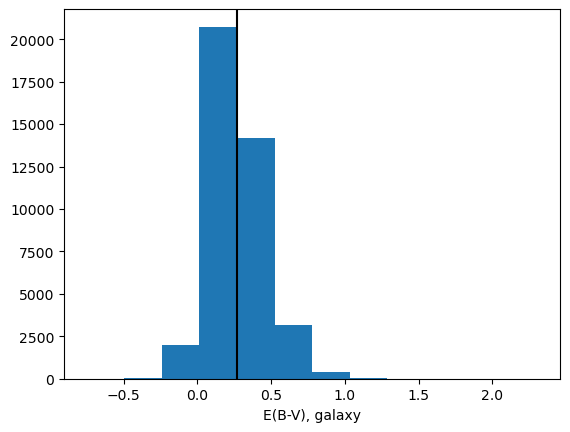

In [14]:
plt.figure()
plt.hist(ebv,12)
plt.axvline(np.mean(ebv),c='k')
plt.xlabel('E(B-V), galaxy')

## Correct for dust extinction

In [15]:
f_Ha_corr = f_Ha *dust_corr_factor(l_ha,ebv)
f_Hb_corr = f_Hb *dust_corr_factor(l_hb,ebv)

In [16]:
O3_4959_corr = O3_4959*dust_corr_factor(l_O3_4959,ebv)
O3_5007_corr = O3_5007*dust_corr_factor(l_O3_5007,ebv)
O2_3726_corr = O2_3726*dust_corr_factor(l_O2_3726,ebv)
O2_3729_corr = O2_3729*dust_corr_factor(l_O2_3729,ebv)
O2_3729_corr = O2_3729*dust_corr_factor(l_O2_3729,ebv)
N2_6584_corr =N2_6584*dust_corr_factor(l_N2_6585,ebv)

In [17]:
O32_I18_corr = O32_I18(O3_5007_corr,O2_3726_corr)
logO32_I18_corr = np.log10(O32_I18_corr)
logO32_I18_corr_h = np.where(np.isinf(logO32_I18_corr),np.nan,logO32_I18_corr)
O32_F22_corr = O32_F22(O3_5007_corr,O2_3726_corr,O2_3729_corr)
logO32_F22_corr = np.log10(O32_F22_corr)
logO32_F22_corr_h = np.where(np.isinf(logO32_F22_corr),np.nan,logO32_F22_corr)
O32_P22_corr = O32_P22(O3_4959_corr,O3_5007_corr,O2_3726_corr,O2_3729_corr)
logO32_P22_corr = np.log10(O32_P22_corr)
logO32_P22_corr_h = np.where(np.isinf(logO32_P22_corr),np.nan,logO32_P22_corr)


/Users/alereste/anaconda3/envs/O32_merg/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [18]:
O32_I18_obs = O32_I18(O3_5007,O2_3726)
logO32_I18_obs = np.log10(O32_I18_obs)
logO32_I18_obs_h = np.where(np.isinf(logO32_I18_obs),np.nan,logO32_I18_obs)
O32_F22_obs = O32_F22(O3_5007,O2_3726,O2_3729)
logO32_F22_obs = np.log10(O32_F22_obs)
logO32_F22_obs_h = np.where(np.isinf(logO32_F22_obs),np.nan,logO32_F22_obs)
O32_P22_obs = O32_P22(O3_4959,O3_5007,O2_3726,O2_3729)
logO32_P22_obs = np.log10(O32_P22_obs)
logO32_P22_obs_h = np.where(np.isinf(logO32_P22_obs),np.nan,logO32_P22_obs)


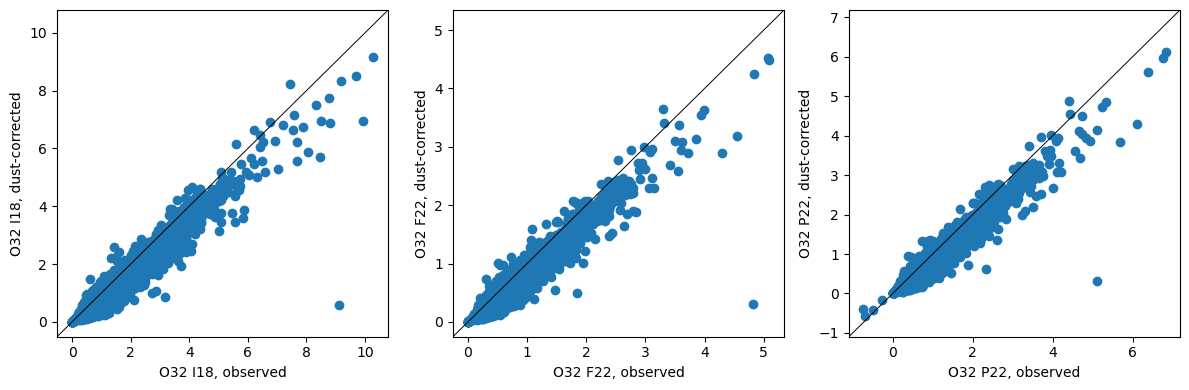

In [19]:
fig = plt.figure(figsize=(3*4,1*4))

ax0 = fig.add_subplot(1, 3, 1)
minv = np.min([O32_I18_obs,O32_I18_corr])
maxv = np.max([O32_I18_obs,O32_I18_corr])
minv -=5/100*maxv
maxv +=5/100*maxv
rangev = np.linspace(minv,maxv,100)
ax0.scatter(O32_I18_obs,O32_I18_corr)
ax0.plot(rangev,rangev,c='k',lw=0.7)
ax0.set_xlabel('O32 I18, observed')
ax0.set_ylabel('O32 I18, dust-corrected')
ax0.set_xlim([minv,maxv])
ax0.set_ylim([minv,maxv])

ax1 = fig.add_subplot(1, 3, 2)
minv = np.min([O32_F22_obs,O32_F22_corr])
maxv = np.max([O32_F22_obs,O32_F22_corr])
minv -=5/100*maxv
maxv +=5/100*maxv
rangev = np.linspace(minv,maxv,100)
ax1.scatter(O32_F22_obs,O32_F22_corr)
ax1.plot(rangev,rangev,c='k',lw=0.7)
ax1.set_xlabel('O32 F22, observed')
ax1.set_ylabel('O32 F22, dust-corrected')
ax1.set_xlim([minv,maxv])
ax1.set_ylim([minv,maxv])

ax2 = fig.add_subplot(1, 3, 3)
minv = np.min([O32_P22_obs,O32_P22_corr])
maxv = np.max([O32_P22_obs,O32_P22_corr])
minv -=5/100*maxv
maxv +=5/100*maxv
rangev = np.linspace(minv,maxv,100)
ax2.scatter(O32_P22_obs,O32_P22_corr)
ax2.plot(rangev,rangev,c='k',lw=0.7)
ax2.set_xlabel('O32 P22, observed')
ax2.set_ylabel('O32 P22, dust-corrected')
ax2.set_xlim([minv,maxv])
ax2.set_ylim([minv,maxv])

plt.tight_layout()

## Make figures

In [69]:
logm = t['logMass']
ssfr = t['ssfr']
logsfr = ssfr + logm 

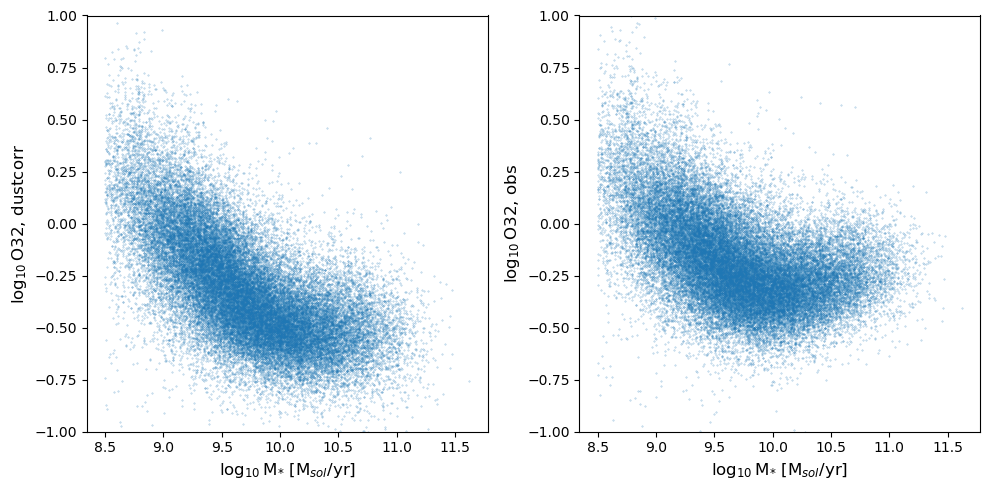

In [70]:
fig = plt.figure(figsize=(2*5,1*5))

ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(logm,np.log10(O32_I18_corr),s=0.1,alpha=0.5)
ax0.set_ylim([-1,1])
ax0.set_ylabel(r'log$_{10}\,$O32, dustcorr',fontsize=12)
ax0.set_xlabel(r'log$_{10}\,$M$_{*}$ [M$_{sol}$/yr]',fontsize=12)

ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(logm,np.log10(O32_I18_obs),s=0.1,alpha=0.5)
ax1.set_ylim([-1,1])
ax1.set_ylabel(r'log$_{10}\,$O32, obs',fontsize=12)
ax1.set_xlabel(r'log$_{10}\,$M$_{*}$ [M$_{sol}$/yr]',fontsize=12)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(2*5,1*5))

ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(logm,np.log10(O32_I18_corr),s=0.1,alpha=0.5)
ax0.set_ylim([-1,1])
ax0.set_ylabel(r'log$_{10}\,$O32, dustcorr',fontsize=12)
ax0.set_xlabel(r'log$_{10}\,$M$_{*}$ [M$_{sol}$/yr]',fontsize=12)

ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(logm,np.log10(O32_I18_obs),s=0.1,alpha=0.5)
ax1.set_ylim([-1,1])
ax1.set_ylabel(r'log$_{10}\,$O32, obs',fontsize=12)
ax1.set_xlabel(r'log$_{10}\,$M$_{*}$ [M$_{sol}$/yr]',fontsize=12)
plt.tight_layout()

### BPT selection

(-1.5, 1.5)

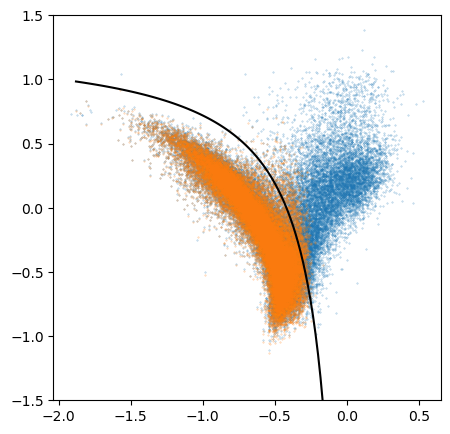

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(1*5,1*5))

y= np.log10(O3_5007_corr.value/f_Hb_corr.value)
x= np.log10(N2_6584_corr.value/f_Ha_corr.value)

y2=  np.log10(primary_catalog['oiii_5007_flux']/primary_catalog['h_beta_flux'] )
x2=  np.log10(primary_catalog['nii_6584_flux']/primary_catalog['h_alpha_flux'] )

xrange = np.linspace(np.nanmin(x),np.nanmax(x),100)

ax0 = fig.add_subplot(1, 1, 1)
ax0.scatter(x2,y2,s=0.1,alpha=0.5)
ax0.scatter(x,y,s=0.1,alpha=0.5)
ax0.plot(xrange,0.61/(xrange-0.05) + 1.3,label = 'K03 selection',c='k')
ax0.set_ylim([-1.5,1.5])
#ax0.set_ylabel(r'log$_{10}\,$O32, dustcorr',fontsize=12)
#ax0.set_xlabel(r'log$_{10}\,$M$_{*}$ [M$_{sol}$/yr]',fontsize=12)


In [23]:
np.unique(y>0.61/(x-0.05) + 1.3)

array([False,  True])

Still have some issues with removing part of the AGNs-- will look into it.

### Look at pair catalog

/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/409797046.py:32: RuntimeWarning: divide by zero encountered in log10
  ebv = -2.5 * np.log10(fHa/fHb/ha_hb_int)/(k_Cardelli(l_Ha)-k_Cardelli(l_Hb))
/var/folders/xf/gdnc5b2x6jjdr7g00v0lcx740000gn/T/ipykernel_17319/409797046.py:3: RuntimeWarning: invalid value encountered in divide
  return(O3_5007/O2_3727)


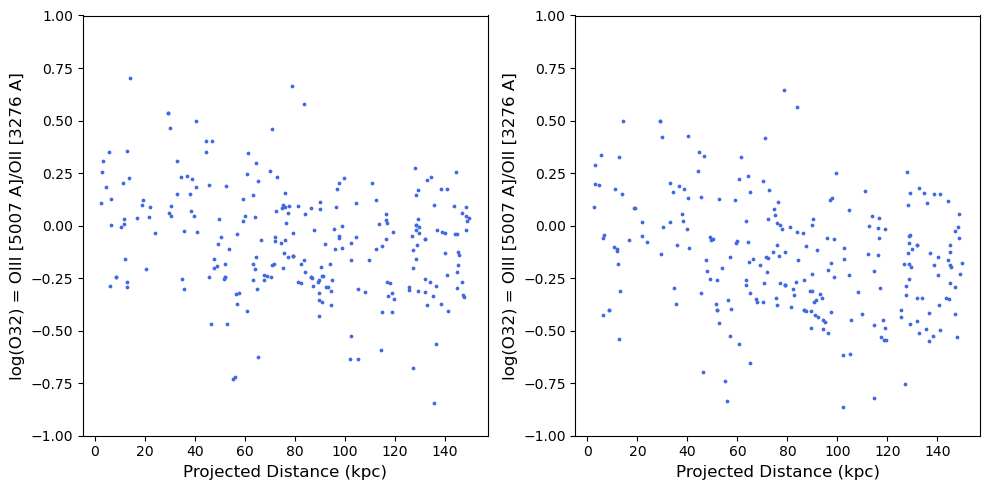

In [39]:
fig = plt.figure(figsize=(2*5,1*5))

proj_dist_pair = []
O32_pair = []

ax0 = fig.add_subplot(1, 2, 1)
for each in pair_catalog[np.where(pair_catalog['mass_ratio']<=0.3)]:
    prim = each['primary_ObjID']
    data_entry = secondary_catalog[np.where(secondary_catalog['ObjID'] == prim)]
    if len(data_entry)==1 and data_entry['logMass']<=9.5:
        O32 = data_entry['oiii_5007_flux']/data_entry['oii_3726_flux']
        ax0.scatter(each['proj_sep'], np.log10(O32),s=3,c='royalblue')

ax0.set_ylim([-1,1])
ax0.set_xlabel('Projected Distance (kpc)', fontsize=12)
ax0.set_ylabel('log(O32) = OIII [5007 A]/OII [3276 A]', fontsize=12)

ax1 = fig.add_subplot(1, 2, 2)
for each in pair_catalog[np.where(pair_catalog['mass_ratio']<=0.3)]:
    prim = each['primary_ObjID']
    data_entry = secondary_catalog[np.where(secondary_catalog['ObjID'] == prim)]
    if len(data_entry)==1 and data_entry['logMass']<=9.5:

        ebv = EBV(data_entry['h_alpha_flux'],data_entry['h_beta_flux'],ha_hb_int=2.87)
        O3_5007_corr = data_entry['oiii_5007_flux']*dust_corr_factor(l_O3_5007,ebv)
        O2_3726_corr = data_entry['oii_3726_flux']*dust_corr_factor(l_O2_3726,ebv)
        O32_corr  = O32_I18(O3_5007_corr,O2_3726_corr)
        proj_dist_pair.append(each['proj_sep'])
        O32_pair.append(O32_corr.value)
        ax1.scatter(each['proj_sep'], np.log10(O32_corr),s=3,c='royalblue')

ax1.set_ylim([-1,1])
ax1.set_xlabel('Projected Distance (kpc)', fontsize=12)
ax1.set_ylabel('log(O32) = OIII [5007 A]/OII [3276 A]', fontsize=12)

plt.tight_layout()
plt.show()


In [40]:
proj_dist_pair = np.array(proj_dist_pair)
O32_pair = np.array(O32_pair).reshape(1, -1)[0]

#### Try fitting

In [56]:
fit = fitting.LinearLSQFitter()
line_init = models.Linear1D()
logO32_pair_model = fit(line_init, proj_dist_pair, np.log10(O32_pair))

Text(0, 0.5, 'log(O32) = OIII [5007 A]/OII [3276 A]')

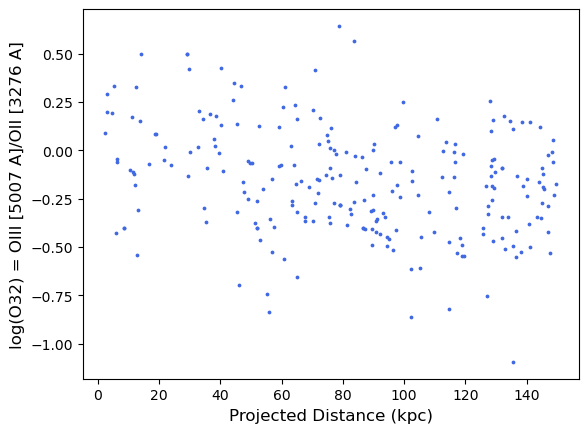

In [44]:
x = np.linspace(np.min(proj_dist_pair),np.max(proj_dist_pair),100)

plt.figure()
plt.scatter(proj_dist_pair, np.log10(O32_pair),s=3,c='royalblue')
plt.plot(x, logO32_pair_model(x),c='k')
plt.xlabel('Projected Distance (kpc)', fontsize=12)
plt.ylabel('log(O32) = OIII [5007 A]/OII [3276 A]', fontsize=12)



In [53]:
#bins = [[-1,50],[50,100],[100,170]]
#bins = [[-1,40],[40,80],[80,120],[120,160]]
bins = [[-1,30],[30,60],[60,90],[90,120],[120,170]]
#bins = [[-1,25],[25,50],[50,75],[75,100],[100,125],[125,175]]
#bins = [[-1,20],[20,40],[40,60],[60,80],[80,100],[100,120],[120,140],[140,160]]
dmed_bin =[] 
ds_bin =[] 
logo32med_bin =[] 
logo32s_bin =[] 

for i,b in enumerate(bins):
  sample_d=[]
  sample_logo32=[]
  for j,d in enumerate(proj_dist_pair):
    if (d>=b[0]) & (d<=b[1]):
      sample_d.append(d)
      sample_logo32.append(np.log10(O32_pair[j]))
  dmed_bin.append(np.nanmedian(np.array(sample_d)))
  ds_bin.append(np.nanstd(np.array(sample_d)))
  logo32med_bin.append(np.nanmedian(np.array(sample_logo32)))
  logo32s_bin.append(np.nanstd(np.array(sample_logo32)))
    
      

Text(0, 0.5, 'log(O32) = OIII [5007 A]/OII [3276 A]')

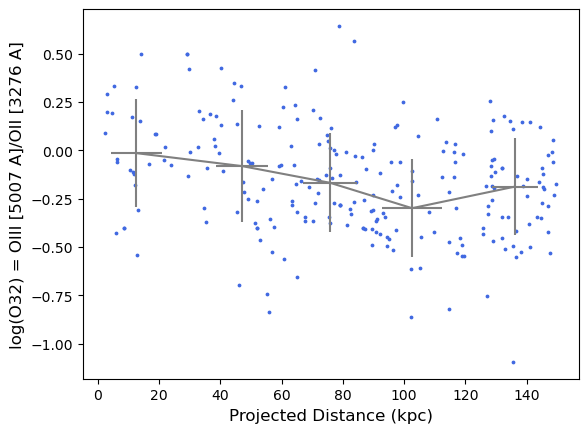

In [54]:
plt.figure()
plt.errorbar(dmed_bin,logo32med_bin,xerr=ds_bin,yerr=logo32s_bin,c='gray')
plt.scatter(proj_dist_pair, np.log10(O32_pair),s=3,c='royalblue')
plt.xlabel('Projected Distance (kpc)', fontsize=12)
plt.ylabel('log(O32) = OIII [5007 A]/OII [3276 A]', fontsize=12)
